#  Data preprocessing and binary classification

## Data source

I'll be making predictions about the survival of the Titanic's passengers, having training data in **data.csv** and evaluation data in **evaluation.csv**.

#### List of features:
* survived - whether passenger survived, 0 = No, 1 = Yes, **explained variable** I want to predict
* pclass - class of ticket, 1 = first, 2 = second, 3 = third
* name - passenger's name
* sex - passenger's sex
* age - age in years
* sibsp	- number of siblings/spouses on board
* parch - number of parents/children on board
* ticket - ticket number
* fare - price of the boat ticket
* cabin	- cabin number
* embarked	- place of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - residence/destination


## Submission notes

  * I'll read the evaluation data from the **evaluation.csv** file, calculate the predictions for these data (the explained variable is no longer in them), create a **results.csv** file to store these predictions in two columns: `ID`, `survival prediction`.
  * Also I'll create a csv file with the predictions and save it within the project (**results.csv**, next to the ipython notebook).

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

## Data: basic overview
* I'll use the `pandas` package to load the data and do some basic exploration.


In [2]:
import pandas as pd
import numpy as np

# suppress scientific float notation (so 0.000 is printed as 0.)
np.set_printoptions(precision=5, suppress=True)

In [3]:
data = pd.read_csv('data.csv')

In [4]:
def separation():
    print('***************************************\n')
def describe_df(df):
    print('shape of dataset: ' + str(df.shape))
    separation()
    print('head of dataset')
    display(df.head())
    separation()
    print('info')
    display(df.info())
    separation()
    print('description')
    display(df.describe())
    separation()
    print('number of unique values')
    display(df.nunique())

In [5]:
describe_df(data)

shape of dataset: (1000, 13)
***************************************

head of dataset


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,NaN
1,1,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,"Australia Fingal, ND"
2,2,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S,Belfast
3,3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,NaN
4,4,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C,"New York, NY"


***************************************

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      222 non-null    object 
 11  embarked   999 non-null    object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None

***************************************

description


,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.000000,1000.000000,797.000000,1000.000000,1000.000000,999.000000
mean,499.500000,0.391000,2.293000,30.006692,0.499000,0.384000,33.418514
std,288.819436,0.488219,0.840153,14.240416,1.020314,0.873675,53.115334
min,0.000000,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,249.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,499.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,749.250000,1.000000,3.000000,38.500000,1.000000,0.000000,31.275000
max,999.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


***************************************

number of unique values


ID           1000
survived        2
pclass          3
name          999
sex             2
age            94
sibsp           7
parch           7
ticket        754
fare          249
cabin         156
embarked        3
home.dest     314
dtype: int64

## Data preparation before splitting
* I'll get rid of the `ID` and `name` columns because the information they contain has no effect on passenger survival statistics.

In [6]:
data = data.drop(['ID', 'name'], axis=1)

* If there are duplicate lines of data in the file, I remove them.

In [7]:
data = data.drop_duplicates()

* I will check if there are data points in the dataset for which there is no explained variable.

In [8]:
print('Amount of data points with no explained variable: ' + str(data.sex.isnull().values.sum()))

Amount of data points with no explained variable: 0


### Missing values
* Some values are missing, but `pandas` reports that none are missing. It may happen that the missing values are not coded correctly, and instead of `NaN` there will be a question mark `?` or a dash `'-'` or `'unknown'`/`Unknown'` will be given.
* In this case, I am replacing any errors when filling the file with `np.nan`.

In [9]:
def replace_values_with_nan(df):
    df = df.replace('?', np.nan)
    df = df.replace('-', np.nan)
    df = df.replace('unknown', np.nan)
    df = df.replace('Unknown', np.nan)
    return df
data = replace_values_with_nan(data)

## Data splitting

In [10]:
from sklearn.model_selection import train_test_split
random_seed = 47

xtrain, xval, ytrain, yval = train_test_split(data.drop(columns=['survived']), data['survived'], test_size=0.4, random_state=random_seed)
xval, xtest, yval, ytest = train_test_split(xval, yval, test_size=0.5, random_state=random_seed)

In [11]:
print(f'Train df size, X: {xtrain.shape}, Y: {ytrain.shape}')
print(f'Validation df size, X: {xval.shape}, Y: {yval.shape}')
print(f'Test df size, X: {xtest.shape}, Y: {ytest.shape}')

Train df size, X: (592, 10), Y: (592,)
Validation df size, X: (197, 10), Y: (197,)
Test df size, X: (198, 10), Y: (198,)


## Data preparation before using the model

* The decision tree implementation in `sklearn` cannot handle non-numeric values. Therefore, I will replace strings with their codes.

In [12]:
display(xtrain.dtypes)

pclass         int64
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

In [13]:
xtrain.sex.unique()

array(['male', 'female'], dtype=object)

* I'll substitute **'male'** and **'female'** for the bool values. I set if `xtrain.sex == 'male'` - then it's True, otherwise it's False.
* So the **'male'** value will be converted to True and **'female'** to False.

In [14]:
def convert_sex(df):
    df.sex = (df.sex=='male')
    return df

xtrain = convert_sex(xtrain)
xval = convert_sex(xval)
xtest = convert_sex(xtest)

* The non-numeric `embarked` feature is **nominal** and I will convert it to a **one-hot encoding** representation.

In [15]:
def one_hot_encoding(df, column_name):
    return pd.get_dummies(df, columns=[column_name])

xtrain = one_hot_encoding(xtrain,'embarked')
xval = one_hot_encoding(xval,'embarked')
xtest = one_hot_encoding(xtest,'embarked')

All features with values of the string type are not continuous, but so called **categorical** (discrete).
  * I will replace all of them with numeric codes.
  * I will convert them to numeric representation using `...cat.codes`.

In [16]:
def cat_codes(df): 
    obj_columns = df.select_dtypes('object').columns
    df[obj_columns] = df[obj_columns].astype('category').apply(lambda x: x.cat.codes)
    return df

xtrain = cat_codes(xtrain)
xval = cat_codes(xval)
xtest = cat_codes(xtest)

* Finally, I will replace all missing values with -1.

In [17]:
def replace_missing(df):
    return df.fillna('-1')

xtrain = replace_missing(xtrain)
xval = replace_missing(xval)
xtest = replace_missing(xtest)

## Using the decision tree implemented in `sklearn`

In [18]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=50)
display(dtc.get_params())
dtc.fit(xtrain, ytrain)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

DecisionTreeClassifier(max_depth=50)

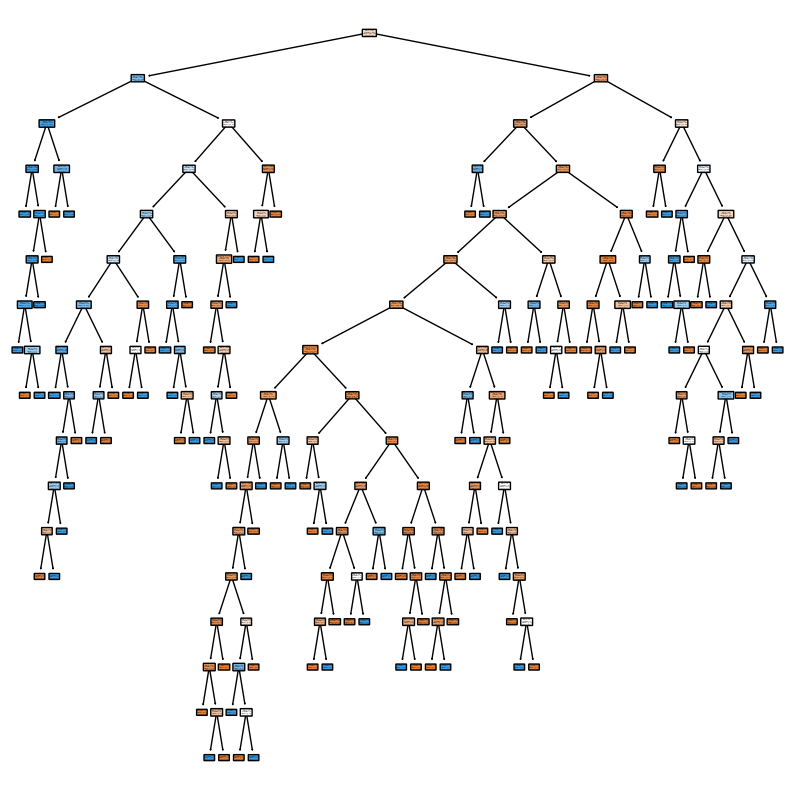

In [19]:
# what the resulting tree looks like
from sklearn.tree import plot_tree
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plot_tree(dtc, filled=True, feature_names=xtrain.iloc[:,:].columns, class_names=True, rounded=True);

In [20]:
import sklearn.metrics as metrics

def acc_score_print(df_type, y_data, x_data, model):
    acc = metrics.accuracy_score(y_data, model.predict(x_data))
    
    if df_type == 'train':
        print(f'Training accuracy score: {acc:.6f}')
    elif df_type == 'val':
        print(f'Validation accuracy score: {acc:.6f}')
    elif df_type == 'test':
        print(f'Testing accuracy score: {acc:.6f}')

               
acc_score_print('train', ytrain, xtrain, dtc)

Training accuracy score: 1.000000


* Accuracy on the training data (for `max_depth` = 50) is 100%
* But it won't be so great with testing data:

In [21]:
acc_score_print('test', ytest, xtest, dtc)

Testing accuracy score: 0.707071


### Tuning hyperparameters `max_depth` and `criterion`
* I'll start with the `max_depth` hyperparameter
* I'll use a validation set.

In [22]:
val_accuracy = []
train_accuracy = []

depths = range(1,100)
for depth in depths:
    dtc = DecisionTreeClassifier(max_depth=depth)
    dtc.fit(xtrain, ytrain)
    train_accuracy.append(metrics.accuracy_score(ytrain, dtc.predict(xtrain)))
    val_accuracy.append(metrics.accuracy_score(yval, dtc.predict(xval)))

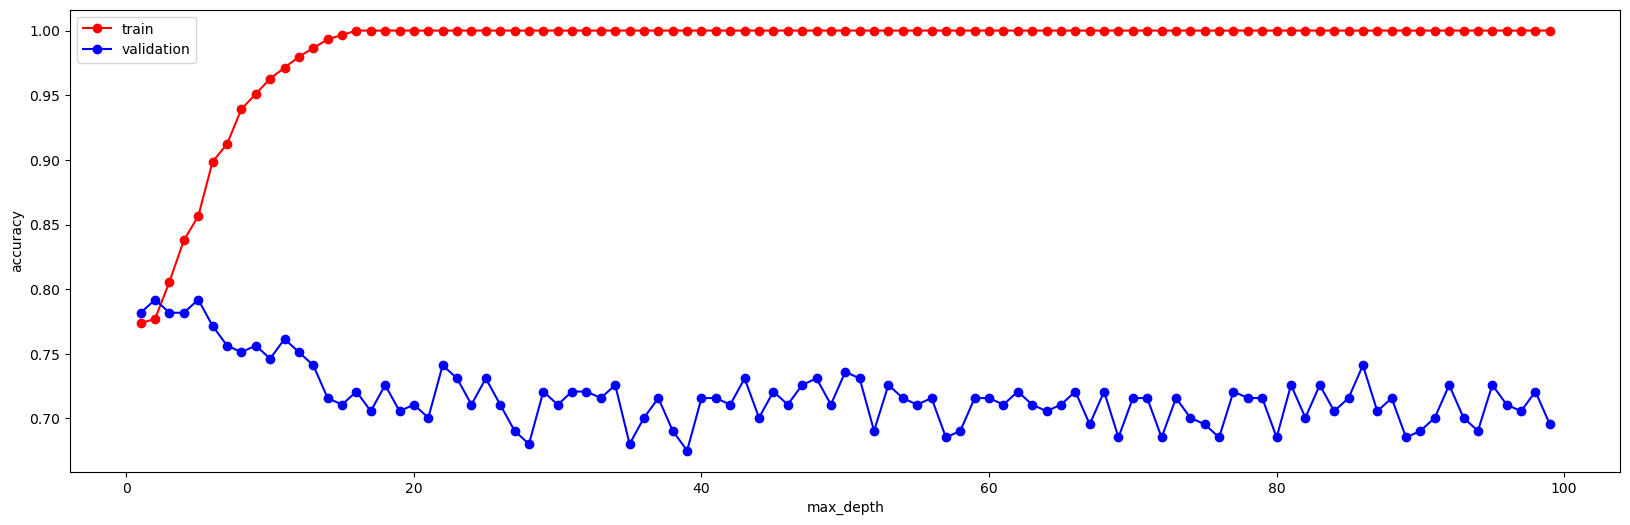

In [23]:
plt.figure(figsize=(20,6))
plt.plot(depths, train_accuracy,'or-')
plt.plot(depths, val_accuracy,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
_ = plt.legend(['train', 'validation'])

In [24]:
optimal_depth = np.argmax(val_accuracy) + 1
print('Optimal depth is: ' + str(optimal_depth))

Optimal depth is: 2


* Calculate **validation accuracy** for the best found value of `max_depth`:

In [25]:
dtc = DecisionTreeClassifier(max_depth=optimal_depth)
dtc.fit(xtrain, ytrain)
acc_score_print('val', yval, xval, dtc)

Validation accuracy score: 0.791878


### Grid search: tuning multiple hyperparameters
* I want to go through the values of `max_depth` and both possible values of `criterion`.

In [26]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'max_depth': range(1,45), 
    'criterion': ['entropy', 'gini'],
    'splitter': ['best', 'random']
}
param_comb = ParameterGrid(param_grid)

In [27]:
val_accuracy = []
train_accuracy = []

for params in param_comb:
    dtc = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'], splitter=params['splitter'])
    dtc.fit(xtrain, ytrain)
    train_accuracy.append(metrics.accuracy_score(ytrain, dtc.predict(xtrain)))
    val_accuracy.append(metrics.accuracy_score(yval, dtc.predict(xval)))

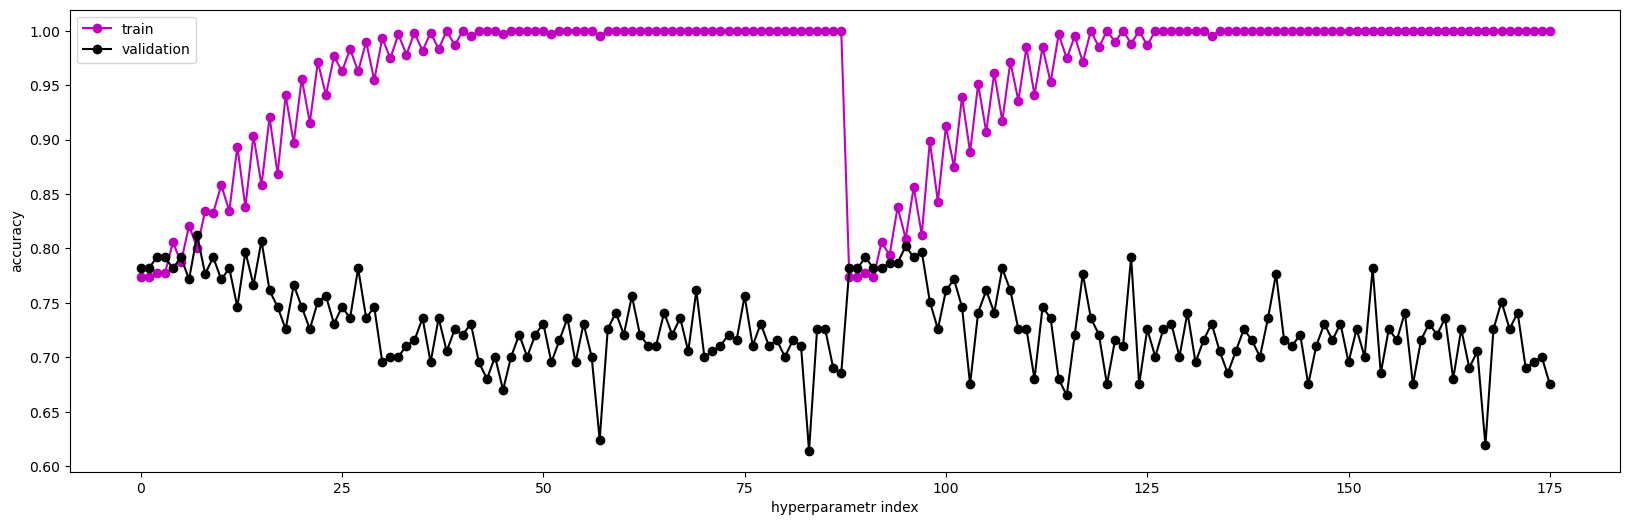

In [28]:
plt.figure(figsize=(20,6))
plt.plot(train_accuracy,'om-')
plt.plot(val_accuracy,'ok-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
_ = plt.legend(['train', 'validation'])

In [29]:
best_params = param_comb[np.argmax(val_accuracy)]

print('Best parameters: ' + str(best_params))
print('Training accuracy: {0:.6f}'.format(train_accuracy[np.argmax(train_accuracy)]))
print('Validation accuracy: {0:.6f}'.format(val_accuracy[np.argmax(val_accuracy)]))

Best parameters: {'splitter': 'random', 'max_depth': 4, 'criterion': 'entropy'}
Training accuracy: 1.000000
Validation accuracy: 0.812183


In [30]:
dtc_grid = DecisionTreeClassifier(**best_params)
dtc_grid.fit(xtrain, ytrain)

acc_score_print('train', ytrain, xtrain, dtc_grid)
acc_score_print('val', yval, xval, dtc_grid)

Training accuracy score: 0.802365
Validation accuracy score: 0.817259


##  KNN method
* I'll use `KNeighborsClassifier` from the `sklearn` library.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(xtrain, ytrain)
acc_score_print('val', yval, xval, knn)

Validation accuracy score: 0.629442


* Improve the result by trying Normalization.

### Data normalization
* I'll try **min-max normalization** using the `MinMaxScaler` class from the `sklearn.preprocessing` module.

In [32]:
from sklearn.preprocessing import MinMaxScaler

# fit and transform the min-max scaler to the training data
scaler = MinMaxScaler()
xtrain_scaled = scaler.fit_transform(xtrain)

# then apply the same transformation to the validation and test data
xval_scaled = scaler.transform(xval)
xtest_scaled = scaler.transform(xtest)

# train the model on the transformed data
knn = KNeighborsClassifier()
knn.fit(xtrain_scaled, ytrain)

acc_score_print('train', ytrain, xtrain_scaled, knn)
acc_score_print('val', yval, xval_scaled, knn)

Training accuracy score: 0.854730
Validation accuracy score: 0.786802


### Grid search KNN
* I want to go through the values of `n_neighbors`, possible values of `weights`, `algorithm` and `metric`.

In [33]:
param_grid_knn = {
    'n_neighbors': range(3, 35),
    'weights': ['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
param_comb_knn = ParameterGrid(param_grid_knn)

In [34]:
val_accuracy_knn = []
train_accuracy_knn = []

for params in param_comb_knn:
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], weights=params['weights'], algorithm=params['algorithm'], metric=params['metric'])
    knn.fit(xtrain_scaled, ytrain)
    train_accuracy_knn.append(metrics.accuracy_score(ytrain, knn.predict(xtrain_scaled)))
    val_accuracy_knn.append(metrics.accuracy_score(yval, knn.predict(xval_scaled)))

In [35]:
best_params_knn = param_comb_knn[np.argmax(val_accuracy_knn)]
print('Best parameters: ' + str(best_params_knn))
print('Training accuracy: {0:.6f}'.format(train_accuracy_knn[np.argmax(train_accuracy_knn)]))
print('Validation accuracy: {0:.6f}'.format(val_accuracy_knn[np.argmax(val_accuracy_knn)]))

Best parameters: {'weights': 'distance', 'n_neighbors': 18, 'metric': 'manhattan', 'algorithm': 'auto'}
Training accuracy: 1.000000
Validation accuracy: 0.827411


In [36]:
knn_grid = KNeighborsClassifier(**best_params_knn)
knn_grid.fit(xtrain_scaled, ytrain)

acc_score_print('train', ytrain, xtrain_scaled, knn_grid)
acc_score_print('val', yval, xval_scaled, knn_grid)

Training accuracy score: 1.000000
Validation accuracy score: 0.827411


## Sum up better model
* Decision Tree Classifier

In [37]:
acc_score_print('val', yval, xval, dtc)

Validation accuracy score: 0.675127


* Decision Tree Classifier with Grid Search

In [38]:
acc_score_print('val', yval, xval, dtc_grid)

Validation accuracy score: 0.817259


* k-Nearest Neighbors scaled

In [39]:
acc_score_print('val', yval, xval_scaled, knn)

Validation accuracy score: 0.796954


* k-Nearest Neighbors scaled with Grid Search

In [40]:
acc_score_print('val', yval, xval_scaled, knn_grid)

Validation accuracy score: 0.827411


 ## Conclusion
 I see that the KNN scaled with grid search model gives a highest accuracy score than other models, it has highest score: 82.7%
 Therefore, I calculate the predictions for the data with dataset `Evaluation.csv` using that KNN model.

In [41]:
# final accuracy score for testing set
acc_score_print('test', ytest, xtest_scaled, knn_grid)

Testing accuracy score: 0.803030


## Evaluation: basic overview
* I load the data from the `evaluation.csv` dataset and examine this dataset.

In [42]:
evaluation = pd.read_csv('evaluation.csv')
describe_df(evaluation)

shape of dataset: (309, 12)
***************************************

head of dataset


,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1000,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,36928,164.8667,C7,S,"Youngstown, OH"
1,1001,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C,NaN
2,1002,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"Scituate, MA"
3,1003,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S,NaN
4,1004,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q,NaN


***************************************

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         309 non-null    int64  
 1   pclass     309 non-null    int64  
 2   name       309 non-null    object 
 3   sex        309 non-null    object 
 4   age        249 non-null    float64
 5   sibsp      309 non-null    int64  
 6   parch      309 non-null    int64  
 7   ticket     309 non-null    object 
 8   fare       309 non-null    float64
 9   cabin      73 non-null     object 
 10  embarked   308 non-null    object 
 11  home.dest  172 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 29.1+ KB


None

***************************************

description


,ID,pclass,age,sibsp,parch,fare
count,309.000000,309.000000,249.000000,309.000000,309.000000,309.000000
mean,1154.000000,2.300971,29.479251,0.498382,0.388350,32.897708
std,89.344838,0.831619,14.976391,1.109652,0.840142,47.185050
min,1000.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,1077.000000,2.000000,20.000000,0.000000,0.000000,7.925000
50%,1154.000000,3.000000,28.000000,0.000000,0.000000,13.000000
75%,1231.000000,3.000000,39.000000,1.000000,0.000000,31.387500
max,1308.000000,3.000000,80.000000,8.000000,6.000000,263.000000


***************************************

number of unique values


ID           309
pclass         3
name         309
sex            2
age           71
sibsp          7
parch          6
ticket       277
fare         156
cabin         66
embarked       3
home.dest    132
dtype: int64

### Data preparation before using the model
* I separate the `ID` column, then append it to the survivor/non-survivor result in the data frame.

In [43]:
evaluation_id = evaluation['ID']
evaluation = evaluation.drop(['ID', 'name'], axis=1)

#### When preparing the dataset `Evaluation.csv` I perform the same operations that I performed when preparing the dataset `Data.csv` : 
* I'll deal with the missing values.

In [44]:
evaluation = replace_values_with_nan(evaluation)

* Replace **'male'** and **'female'** with bool values.

In [45]:
evaluation = convert_sex(evaluation)

* Convert the non-numeric `embarked` flag to **one-hot encoding** representation.

In [46]:
evaluation = one_hot_encoding(evaluation,'embarked')

  * I will replace all flags with string values with numeric codes.
  * I convert them to numeric representation.

In [47]:
evaluation = cat_codes(evaluation)

* Replace all missing values with -1.

In [48]:
evaluation = replace_missing(evaluation)

### Normalize the `Evaluation` dataset for further prediction

In [49]:
scaler = MinMaxScaler()
evaluation_scaled = scaler.fit_transform(evaluation)

* I'll calculate predictions for the normalized data from the file.

In [50]:
predicted = knn_grid.predict(evaluation_scaled)

I store the predictions in two columns: `ID`, `survival prediction` in the **results.csv** file.

In [51]:
predicted = pd.Series(data=predicted, name='survived')
predicted_df = pd.concat([evaluation_id, predicted], axis=1)
predicted_df.to_csv('results.csv', index=False)